In [2]:
import os
currentPath = os.getcwd()
print(currentPath)
os.chdir('/Users/jaekunpark/jupyter_project')

/Users/jaekunpark/jupyter_project


In [ ]:
Use the intermediate layers of the model to get the content and style representations of the image.
Starting from the networks input layer, the first few layer activations represent
low-level features like edges and textures.
As you step through the network, the final few layers represent higher-level features—object parts 
like wheels or eyes. In this case, you are using the VGG19 network architecture, a pretrained image classification
network. These intermediate layers are necessary to define the representation of content and style from the images.
For an input image, try to match the corresponding style and content target representations 
at these intermediate layers.


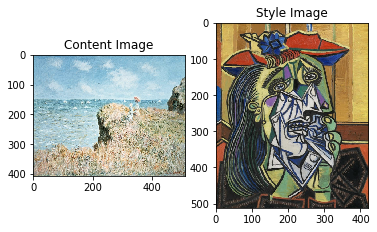

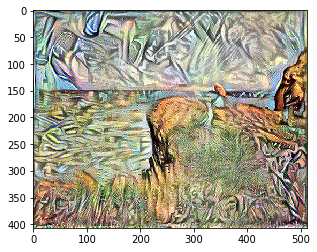

CPU times: user 47min 43s, sys: 1min 39s, total: 49min 22s
Wall time: 7min 30s


In [4]:
%%time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.datasets import load_sample_image
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

content_path = '/Users/jaekunpark/jupyter_project/Monet0.jpg'
style_path = '/Users/jaekunpark/jupyter_project/Picasso.jpg'
content_image = tf.image.decode_image(tf.io.read_file(content_path), channels=3)
style_image = tf.image.decode_image(tf.io.read_file(style_path), channels=3)

def preprocess_img(img):
    "이미지 가로 길이를 512로 통일"

    # 0~255 uint 자료형을 0 ~ 1 실수 자로형으로 변환한다.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 이미지 크기
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    # 이미지의 가로, 세로 중 긴 변의 값(가로 길이)
    long_dim = max(shape)
    # 이미지의 목표 가로 길이
    max_dim = 512
    # 목표 크기와의 비율
    scale = max_dim / long_dim
    # 새 크기
    new_shape = tf.cast(shape * scale, tf.int32)
    # 이미지 크기 변화
    img = tf.image.resize(img, new_shape)
    # 1장짜리 배치 데이터(4차원 텐서)로 변환 
    img = img[tf.newaxis, :]
    
    return img

# Image Preprocess
content_image = preprocess_img(content_image)
style_image = preprocess_img(style_image)

# Image Output
plt.subplot(121)
plt.imshow(tf.squeeze(content_image))
plt.title("Content Image")
plt.subplot(122)
plt.imshow(tf.squeeze(style_image))
plt.title("Style Image")
plt.show()

# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)


# Definitions & Classes

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)


class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        "VGG 모형 입력으로부터 스타일 레이어와 내용 레이어를 출력하는 모형을 만든다."
        super(StyleContentModel, self).__init__()
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.num_style_layers = len(style_layers)
        outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
        self.vgg = tf.keras.Model([vgg.input], outputs) 
        self.vgg.trainable = False

    def call(self, inputs):
        "입력"
        # 이미지의 0 ~ 1 입력을 0 ~ 255로 확대
        inputs = inputs * 255.0
        # 이미지넷 데이터의 평균으로 정규화
        preprocessed_input = preprocess_input(inputs)
        # 스타일 레이어와 컨텐트 레이어의 출력
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        # 그램 행렬로 각 레이어의 스타일 출력값 계산
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]
        
        #컨텐트와 스타일 출력을 딕셔너리로 정리
        content_dict = {content_name: value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}
    
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        "VGG 모형 입력으로부터 스타일 레이어와 컨텐트 레이어를 출력하는 모형을 만든다."
        super(StyleContentModel, self).__init__()
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.num_style_layers = len(style_layers)
        outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
        self.vgg = tf.keras.Model([vgg.input], outputs) 
        self.vgg.trainable = False

    def call(self, inputs):
        "입력"
        # 이미지의 0 ~ 1 입력을 0 ~ 255로 확대
        inputs = inputs * 255.0
        # 이미지넷 데이터의 평균으로 정규화
        preprocessed_input = preprocess_input(inputs)
        # 스타일 레이어와 컨텐트 레이어의 출력
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        # 그램 행렬로 각 레이어의 스타일 출력값 계산
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]
        
        #컨텐트와 스타일 출력을 딕셔너리로 정리
        content_dict = {content_name: value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}
    
extractor = StyleContentModel(style_layers, content_layers)

# 참조 이미지의 각 스타일 레이어 출력의 그램 행렬
style_targets = extractor(style_image)['style']

# 목표 이미지의 내용 레이어 출력
content_targets = extractor(content_image)['content']




# To optimize this, use a weighted combination of the two losses to get the total loss:
style_weight = 1e-2
content_weight = 1e4

def style_content_loss(outputs):
    # outputs는 현재 이미지의 스타일 및 내용 출력
    # 현재 이미지의 스타일 출력(의 그램 행렬)
    style_outputs = outputs['style']
    # 현재 이미지의 내용 출력
    content_outputs = outputs['content']
    # 현재 이미지의 스타일 출력과 참조 이미지의 스타일 출력의 차이 계산
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) 
                           for name in style_outputs.keys()])
    # 컨텐트 손실함수 값과 더하기 전에 가중치 부여
    style_loss *= style_weight / num_style_layers
    # 현재 이미지의 내용 출력과 목표 이미지의 내용 출력의 차이 계산
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) 
                             for name in content_outputs.keys()])
    # 가중치 부여
    content_loss *= content_weight / num_content_layers
    # 최종 손실함수 계산
    loss = style_loss + content_loss
    return loss





# The paper recommends LBFGS, but Adam works okay, too:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

def train_step(image):
    with tf.GradientTape() as tape:
        # 현재 이미지에서 스타일 레이어 및 내용 레이어 출력을 계산
        outputs = extractor(image)
        # 현재 이미지의 손실함수값 계산
        loss = style_content_loss(outputs)

    # 그레디언트 벡터 계산
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    
    # 새로운 이미지 저장
    # Since this is a float image, define a function to keep the pixel values between 0 and 1:
    image_clipped = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    image.assign(image_clipped)
    
    


image = tf.Variable(content_image)
for n in range(200):
    train_step(image)
    
plt.imshow(tf.squeeze(image))
plt.show()